# **Neural Networks**

## p4 (K-MNIST Data)

### *Data preprocessing (extraction, splitting)*

In [141]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress = True)
import warnings
warnings.filterwarnings("ignore")

In [147]:
#Data

with open('./Data/p4.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [148]:
Data = np.array(results)
labels = np.unique(Data[:,0].astype(int))
input_features = Data.shape[1] - 1

In [149]:
print(Data.shape)
print(input_features)

(60000, 785)
784


In [133]:
# Splits the data with given percentages

def DataSplit(Data, train_percent, test_percent, val_percent = 0):
    split_list = []
    train_size = int(train_percent * Data.shape[0] / 100)
    val_size = int(val_percent * Data.shape[0] / 100)
    test_size = Data.shape[0] - train_size - val_size
    
    # Train and Test data
    DTrain = np.zeros((train_size, Data.shape[1]))
    DTest = np.zeros((test_size, Data.shape[1]))
    DTrain = Data[0:train_size, :]
    DTest = Data[train_size + val_size: Data.shape[0], :]
    split_list.extend([DTrain, DTest])
    
    # For validataion data
    if val_percent > 0:
        DVal = np.zeros((val_size, Data.shape[1]))
        DVal = Data[train_size: train_size + val_size, :]
        split_list.append(DVal)
    return split_list

In [82]:
def convert_to_one_hot(y, num_classes):
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[np.arange(y.shape[0]), y] = 1
    return y_one_hot

In [83]:
def preprocess_data(X):
    y = X[:, 0].astype(int)
    x = np.delete(X, 0, axis = 1)
    return x, y

In [150]:
split_data = DataSplit(Data, 80, 20)

# Train and Test Data
DTrain = split_data[0]
DTest = split_data[1]
# Validataion Data
if len(split_data) == 3:
    DVal = split_data[2]

### *Fully Connected Layer*

In [85]:
class Layer_FullyConnected:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        
        #Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))   

    def forward(self, inputs):
        
        # calculate the values of the neurons before activation
        # inputs matrix contains features for a sample of data
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights) + self.biases
        return self.output
    
    def backward(self, dvalues):
        
        # dvalues are the upstream gradients
        # dweights, dbiases are the backprop gradients with shape similar to weights matrix and bias vector
        # dinputs are the dvalues for the previous layer with shape similar to inputs
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

### *Input Layer*

In [86]:
class Layer_Input:
    def __init__(self, input_size):
        self.input_size = input_size      
    # Forward pass
    def forward(self, x):
        assert len(x.shape) == 2 and x.shape[1] == self.input_size, f"Input size mismatch: expected ({x.shape[0]}, {self.input_size}), got {x.shape}"
        self.output = x
        return self.output

### *Activations (ReLU, Softmax, Sigmoid, Linear)*

In [87]:
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output
    def backward(self, dvalues): 
        # Here not necessasry to copy the values as we are only using dvalues once
        self.dinputs = dvalues.copy()
        # When the inputs to relu are not positve, make the dinputs zero
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

In [88]:
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probabilities
        return self.output
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        return self.dinputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis = 1)

In [89]:
class Activation_Sigmoid:
    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output
        return self.dinputs

In [90]:
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        return self.dinputs

### *SGD Optimizer*

In [91]:
class Optimizer_SGD: 
    def __init__(self, learning_rate = 1, decay = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0 
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)
    def update_params(self, layer):
        if isinstance(layer, Layer_FullyConnected):
            layer.weights += -self.current_learning_rate * layer.dweights
            layer.biases += -self.current_learning_rate * layer.dbiases   
    def post_update_params(self):
        self.iterations += 1

### *Cross Entropy Loss with Softmax Activation*

In [105]:
class Softmax_CrossEntropyLoss:

    def forward(self, y_pred, y_true, classes):
        
        # y_pred shape: (batch_size, num_classes)
        # y_true shape: (batch_size,)
        batch_size = y_pred.shape[0]
        # Clip y_pred values to prevent log(0) errors
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the log of predicted probabilities for the true class for each example
        log_likelihoods = -np.log(y_pred[range(batch_size), y_true])
        # Compute the mean of the log likelihoods for the batch
        loss = np.mean(log_likelihoods)
        return loss
    
    def backward(self, dvalues, y_true, classes):
          # Number of samples
        samples = len(dvalues)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs

### *Squared Error Loss*

In [104]:
class MeanSquareLoss:
    
    def forward(self, y_pred, y_true, classes):
        y_true_oh = convert_to_one_hot(y_true, len(classes))
        return np.sum((y_pred - y_true_oh) ** 2) / y_pred.shape[0]
#         return np.sum((y_pred - y_true_oh) ** 2)
        
    def backward(self, dvalues, y_true, classes):
        y_true_oh = convert_to_one_hot(y_true, len(classes))
        return 2 * (dvalues - y_true_oh) / dvalues.shape[0] 

### *Neural Network Class*

In [94]:
class NeuralNet:
    
    def __init__(self, input_size, hidden_sizes, output_size, activation, loss, optimizer):
        
        # Layers
        self.input_layer = Layer_Input(input_size)
        self.hidden_layers = []
        self.loss_fn = loss
        self.train_loss = []
        self.optimizer = optimizer
        for i, hidden_size in enumerate(hidden_sizes):
            fc_layer = Layer_FullyConnected(input_size if i == 0 else hidden_sizes[i-1], hidden_size)
            if activation == 'relu':
                activation_layer = Activation_ReLU()
            elif activation == 'sigmoid':
                activation_layer = Activation_Sigmoid()
            elif activation == 'linear':
                activation_layer = Activation_Linear()
            self.hidden_layers.extend([fc_layer, activation_layer])
        self.output_layer = Layer_FullyConnected(hidden_sizes[-1], output_size)
        self.output_softmax_layer = Activation_Softmax()

    def forward(self, x):
        x = self.input_layer.forward(x)
        for layer in self.hidden_layers:
            x = layer.forward(x)
        x = self.output_layer.forward(x)
        x = self.output_softmax_layer.forward(x)
        return x

    def backward(self, y_pred, y_true, classes):
        
         # Compute the derivative of the loss with respect to the output of the model

        dL_dy = self.loss_fn.backward(y_pred, y_true, classes)
        
        if isinstance(self.loss_fn, MeanSquareLoss):
             dL_dy = self.output_softmax_layer.backward(dL_dy)
        
         # backpropagate the derivatives through the output layer
        dL_dx = self.output_layer.backward(dL_dy)
        
        for layer in reversed(self.hidden_layers):
            dL_dx = layer.backward(dL_dx)
    
    def train(self, X, epochs = 1, batch_size = None, val_data = None):
        
        for epoch in range(epochs):
            
            np.random.shuffle(X)
            classes = np.unique(X[:, 0].astype(int))
            epoch_accuracy = 0
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:i + batch_size, :]
                x_batch, y_batch = preprocess_data(batch)
                # Forward pass
                outputs = self.forward(x_batch)
        
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                epoch_accuracy += np.count_nonzero(predictions == y_batch)
                
                # Backward pass 
                self.backward(outputs, y_batch, classes)
                    
                for layer in self.hidden_layers:
                    self.optimizer.pre_update_params()
                    self.optimizer.update_params(layer)
                    self.optimizer.post_update_params()
                self.optimizer.update_params(self.output_layer)
            self.calculate_loss(X)
            print('Epoch: ', epoch + 1, ' Accuracy: ', round(epoch_accuracy * 100 / len(X), 2))
    
    def test(self, X):
        
        test_accuracy = 0
        classes = np.unique(X[:, 0].astype(int))
        x, y = preprocess_data(X)
        # Forward pass
        outputs = self.forward(x)
        predictions = self.output_softmax_layer.predictions(outputs)
        test_accuracy += np.count_nonzero(predictions == y)
        print('\033[1mTest Accuracy = ', round(test_accuracy * 100 / len(X), 2), '\033[0m')
        print('\n')
        self.f1score(predictions, y, len(classes))
        print('\n')
    def calculate_loss(self, X):
        
        train_data, train_labels = preprocess_data(X)
        classes = np.unique(X[:, 0].astype(int))
        outputs = self.forward(train_data)
        self.train_loss.append(self.loss_fn.forward(outputs, train_labels, classes))
            
    def f1score(self, predicted_labels, test_labels, classes):
    
        # Confusion Matrix

        ConfMatrix = np.zeros([classes, classes])

        for i in range(len(test_labels)):
            ConfMatrix[test_labels[i], predicted_labels[i]] += 1

        # Precision

        Precision = []
        for i in range(classes):
            Precision.append(ConfMatrix[i][i] / np.sum(ConfMatrix[:,i]))

        # Recall

        Recall = []
        for i in range(classes):
            Recall.append(ConfMatrix[i][i] / np.sum(ConfMatrix[i,:]))

        # f1 Score

        f1Score = []
        for i in range(classes):
            f1Score.append(2 * Recall[i] * Precision[i] / (Recall[i] + Precision[i]))
            print('f1 Score of Class ', i , ' is: ', f1Score[i])


### *Config - 1 (1 Hidden Layer with 350 neurons)*

In [106]:
def configuration(hidden_sizes, learning_rates):
    loss_fn = [Softmax_CrossEntropyLoss(), MeanSquareLoss()]
    loss_name = ['softmax_ce_loss', 'mse_loss']
#     activations = ['relu', 'linear']
    activations = ['relu', 'linear', 'sigmoid']
    train_loss_list = []
    epochs = 20
    batch_size = 32
    learning_index = 0
    for (i,loss) in enumerate(loss_fn):
        for activation in activations:
            print('\n')
            print('\033[1mNeural Network with', activation , 'activation and', loss_name[i], '\033[0m')
            print('\n')
            optimizer = Optimizer_SGD(learning_rates[learning_index], decay = 0)
            learning_index += 1
            model = NeuralNet(input_features, hidden_sizes, len(labels), activation, loss, optimizer)
            print("#### Training ####")
            print('\n')
            model.train(DTrain, epochs, batch_size)
            print('\n')
            print('#### End of Training ####')
            print('\n')
            model.test(DTest)
            model.f1score 
            train_loss_list.append(model.train_loss)
    plot_lossvepoch(train_loss_list, epochs)

In [107]:
def plot_lossvepoch(train_loss_list, epochs):
    # define the lists to plot
    x = list(range(1, epochs + 1))
#     labels = ['CE loss, relu', 'CE loss, linear', 'CE loss, sigmoid', 'MSE loss, relu', 'MSE loss, linear', 'MSE loss, sigmoid']
    labels = ['CE loss, relu', 'CE loss, linear', 'CE loss, sigmoid', 'MSE loss, relu', 'MSE loss, linear', 'MSE loss, sigmoid']
    # plot the lists
    for i in range(len(train_loss_list)):
        plt.plot(x, train_loss_list[i], label = labels[i])

    # add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend()

    # show the plot
    plt.show()



Neural Network with relu activation and softmax_ce_loss 


#### Training ####


Epoch:  1  Accuracy:  94.93
Epoch:  2  Accuracy:  98.16
Epoch:  3  Accuracy:  98.97
Epoch:  4  Accuracy:  99.4
Epoch:  5  Accuracy:  99.62
Epoch:  6  Accuracy:  99.8
Epoch:  7  Accuracy:  99.88
Epoch:  8  Accuracy:  99.93
Epoch:  9  Accuracy:  99.97
Epoch:  10  Accuracy:  99.99
Epoch:  11  Accuracy:  99.99
Epoch:  12  Accuracy:  99.99
Epoch:  13  Accuracy:  100.0
Epoch:  14  Accuracy:  100.0
Epoch:  15  Accuracy:  100.0
Epoch:  16  Accuracy:  100.0
Epoch:  17  Accuracy:  100.0
Epoch:  18  Accuracy:  100.0
Epoch:  19  Accuracy:  100.0
Epoch:  20  Accuracy:  100.0


#### End of Training ####


Test Accuracy =  98.43 


f1 Score of Class  0  is:  0.9933554817275748
f1 Score of Class  1  is:  0.9916874480465502
f1 Score of Class  2  is:  0.9864141622066693
f1 Score of Class  3  is:  0.9896049896049897
f1 Score of Class  4  is:  0.9912609238451936
f1 Score of Class  5  is:  0.9692307692307691
f1 Score of Class

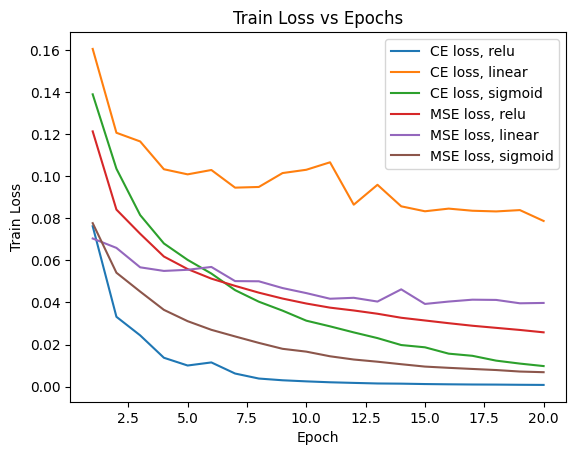

In [137]:
learning_rates = [0.001, 0.0005, 0.01, 0.0001, 0.001, 0.01]
configuration([350], learning_rates)

### *Config - 2 (2 Hidden Layers with 800 and 300 neurons)*



Neural Network with relu activation and softmax_ce_loss 


#### Training ####


Epoch:  1  Accuracy:  93.34
Epoch:  2  Accuracy:  97.01
Epoch:  3  Accuracy:  97.79
Epoch:  4  Accuracy:  98.43
Epoch:  5  Accuracy:  98.78
Epoch:  6  Accuracy:  99.09
Epoch:  7  Accuracy:  99.33
Epoch:  8  Accuracy:  99.47
Epoch:  9  Accuracy:  99.61
Epoch:  10  Accuracy:  99.76
Epoch:  11  Accuracy:  99.78
Epoch:  12  Accuracy:  99.86
Epoch:  13  Accuracy:  99.89
Epoch:  14  Accuracy:  99.93
Epoch:  15  Accuracy:  99.94
Epoch:  16  Accuracy:  99.95
Epoch:  17  Accuracy:  99.96
Epoch:  18  Accuracy:  99.98
Epoch:  19  Accuracy:  99.99
Epoch:  20  Accuracy:  99.98


#### End of Training ####


Test Accuracy =  98.41 


f1 Score of Class  0  is:  0.9896308585649108
f1 Score of Class  1  is:  0.9912463526469362
f1 Score of Class  2  is:  0.987205943045811
f1 Score of Class  3  is:  0.9891936824605153
f1 Score of Class  4  is:  0.9920997920997922
f1 Score of Class  5  is:  0.973594548551959
f1 Score of Class

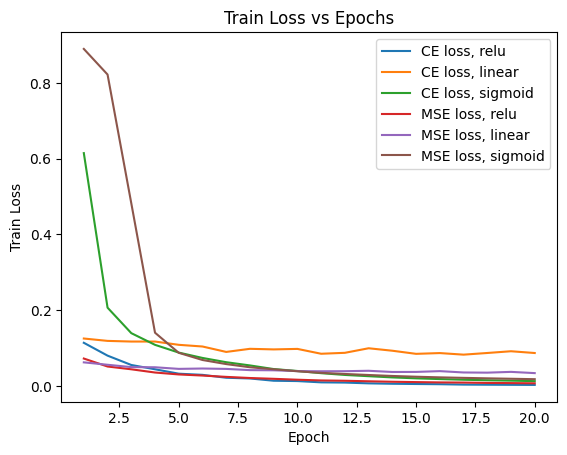

In [111]:
learning_rates = [0.001, 0.002, 0.01, 0.001, 0.002, 0.01]
configuration([800, 300], learning_rates)

### *Config - 3 (3 Hidden Layers with 500, 250, 100 neurons)*



Neural Network with relu activation and softmax_ce_loss 


#### Training ####


Epoch:  1  Accuracy:  65.61
Epoch:  2  Accuracy:  94.24
Epoch:  3  Accuracy:  95.69
Epoch:  4  Accuracy:  96.36
Epoch:  5  Accuracy:  96.88
Epoch:  6  Accuracy:  97.29
Epoch:  7  Accuracy:  97.74
Epoch:  8  Accuracy:  98.01
Epoch:  9  Accuracy:  98.3
Epoch:  10  Accuracy:  98.51
Epoch:  11  Accuracy:  98.72
Epoch:  12  Accuracy:  98.89
Epoch:  13  Accuracy:  99.08
Epoch:  14  Accuracy:  99.16
Epoch:  15  Accuracy:  99.3
Epoch:  16  Accuracy:  99.38
Epoch:  17  Accuracy:  99.49
Epoch:  18  Accuracy:  99.58
Epoch:  19  Accuracy:  99.63
Epoch:  20  Accuracy:  99.67


#### End of Training ####


Test Accuracy =  98.11 


f1 Score of Class  0  is:  0.9892116182572614
f1 Score of Class  1  is:  0.9912536443148688
f1 Score of Class  2  is:  0.9810699588477366
f1 Score of Class  3  is:  0.9822387443205287
f1 Score of Class  4  is:  0.9908713692946057
f1 Score of Class  5  is:  0.9674935842600514
f1 Score of Class

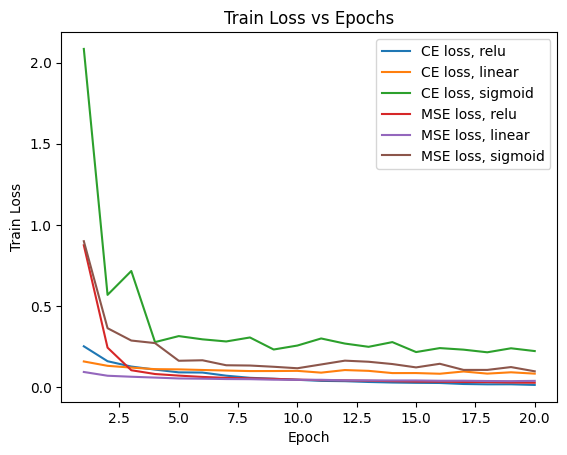

In [151]:
learning_rates = [0.001, 0.002, 0.5, 0.001, 0.002, 0.5]
configuration([500, 250, 100], learning_rates)

## p7 (PCA_MNIST Data)

### *Data preprocessing (extraction, splitting)*

In [152]:
# Data

with open('./Data/PCA_MNIST.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)### *Data preprocessing (extraction, splitting)*

In [153]:
Data = np.array(results)
labels = np.unique(Data[:,0].astype(int))
input_features = Data.shape[1] - 1

In [154]:
print(Data.shape)
print(input_features)

(60000, 11)
10


In [155]:
split_data = DataSplit(Data, 80, 20)
### *Config - 1 (1 Hidden Layer with 350 neurons)*
# Train and Test Data
DTrain = split_data[0]
DTest = split_data[1]
# Validataion Data
if len(split_data) == 3:
    DVal = split_data[2]

### *Config - 1 (1 Hidden Layer with 350 neurons)*



Neural Network with relu activation and softmax_ce_loss 


#### Training ####


Epoch:  1  Accuracy:  92.33
Epoch:  2  Accuracy:  94.3
Epoch:  3  Accuracy:  94.81
Epoch:  4  Accuracy:  95.01
Epoch:  5  Accuracy:  95.25
Epoch:  6  Accuracy:  95.39
Epoch:  7  Accuracy:  95.43
Epoch:  8  Accuracy:  95.51
Epoch:  9  Accuracy:  95.59
Epoch:  10  Accuracy:  95.65
Epoch:  11  Accuracy:  95.74
Epoch:  12  Accuracy:  95.87
Epoch:  13  Accuracy:  95.91
Epoch:  14  Accuracy:  95.81
Epoch:  15  Accuracy:  95.95
Epoch:  16  Accuracy:  95.96
Epoch:  17  Accuracy:  96.05
Epoch:  18  Accuracy:  96.04
Epoch:  19  Accuracy:  96.12
Epoch:  20  Accuracy:  96.15


#### End of Training ####


Test Accuracy =  97.03 


f1 Score of Class  0  is:  0.974190905366653
f1 Score of Class  1  is:  0.9690021231422505
f1 Score of Class  2  is:  0.9908256880733944
f1 Score of Class  3  is:  0.9672667757774142
f1 Score of Class  4  is:  0.9833610648918469
f1 Score of Class  5  is:  0.9776465626318008
f1 Score of Class

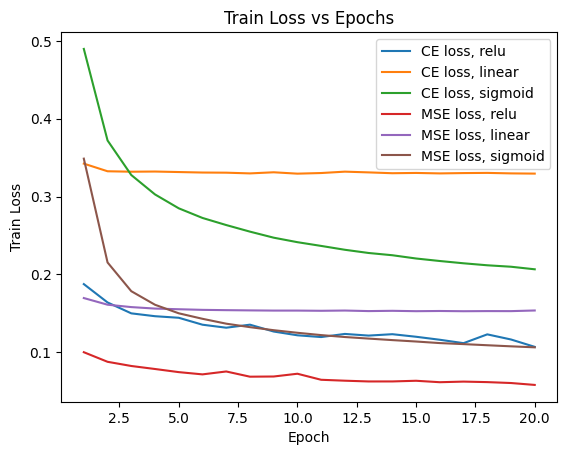

In [129]:
learning_rates = [0.0005, 0.00005, 0.001, 0.0005, 0.00005, 0.001]
#mse-relu = 0.1
configuration([350], learning_rates)

### *Config - 2 (2 Hidden Layers with 800 and 300 neurons)*



Neural Network with relu activation and softmax_ce_loss 


#### Training ####


Epoch:  1  Accuracy:  90.64
Epoch:  2  Accuracy:  93.8
Epoch:  3  Accuracy:  94.46
Epoch:  4  Accuracy:  94.84
Epoch:  5  Accuracy:  95.19
Epoch:  6  Accuracy:  95.4
Epoch:  7  Accuracy:  95.54
Epoch:  8  Accuracy:  95.66
Epoch:  9  Accuracy:  95.85
Epoch:  10  Accuracy:  95.85
Epoch:  11  Accuracy:  95.95
Epoch:  12  Accuracy:  96.01
Epoch:  13  Accuracy:  96.16
Epoch:  14  Accuracy:  96.2
Epoch:  15  Accuracy:  96.28
Epoch:  16  Accuracy:  96.26
Epoch:  17  Accuracy:  96.38
Epoch:  18  Accuracy:  96.41
Epoch:  19  Accuracy:  96.43
Epoch:  20  Accuracy:  96.5


#### End of Training ####


Test Accuracy =  97.31 


f1 Score of Class  0  is:  0.9733715690290864
f1 Score of Class  1  is:  0.9720812182741116
f1 Score of Class  2  is:  0.9941569282136896
f1 Score of Class  3  is:  0.976878612716763
f1 Score of Class  4  is:  0.9816971713810315
f1 Score of Class  5  is:  0.9772535804549284
f1 Score of Class  6

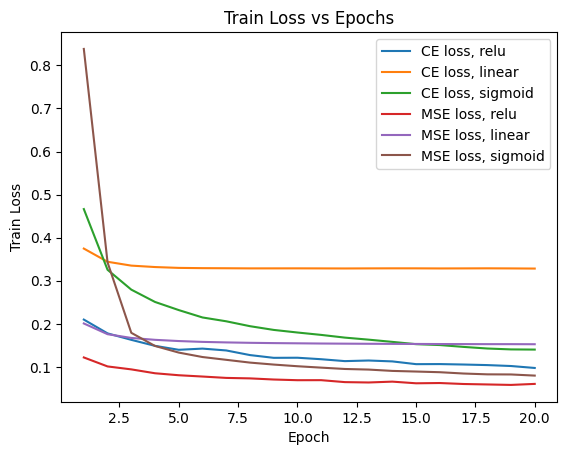

In [121]:
learning_rates = [0.001, 0.0001, 0.01, 0.001, 0.0001, 0.01]
configuration([800, 300], learning_rates)

### *Config - 3 (3 Hidden Layers with 500, 250, 100 neurons)*



Neural Network with relu activation and softmax_ce_loss 


#### Training ####


Epoch:  1  Accuracy:  67.44
Epoch:  2  Accuracy:  89.81
Epoch:  3  Accuracy:  91.83
Epoch:  4  Accuracy:  92.9
Epoch:  5  Accuracy:  93.55
Epoch:  6  Accuracy:  94.03
Epoch:  7  Accuracy:  94.3
Epoch:  8  Accuracy:  94.62
Epoch:  9  Accuracy:  94.77
Epoch:  10  Accuracy:  94.95
Epoch:  11  Accuracy:  95.1
Epoch:  12  Accuracy:  95.25
Epoch:  13  Accuracy:  95.36
Epoch:  14  Accuracy:  95.44
Epoch:  15  Accuracy:  95.52
Epoch:  16  Accuracy:  95.57
Epoch:  17  Accuracy:  95.69
Epoch:  18  Accuracy:  95.66
Epoch:  19  Accuracy:  95.7
Epoch:  20  Accuracy:  95.85


#### End of Training ####


Test Accuracy =  97.42 


f1 Score of Class  0  is:  0.980865224625624
f1 Score of Class  1  is:  0.9807852965747702
f1 Score of Class  2  is:  0.9928900041823504
f1 Score of Class  3  is:  0.967609676096761
f1 Score of Class  4  is:  0.9829804898298049
f1 Score of Class  5  is:  0.9790794979079498
f1 Score of Class  6 

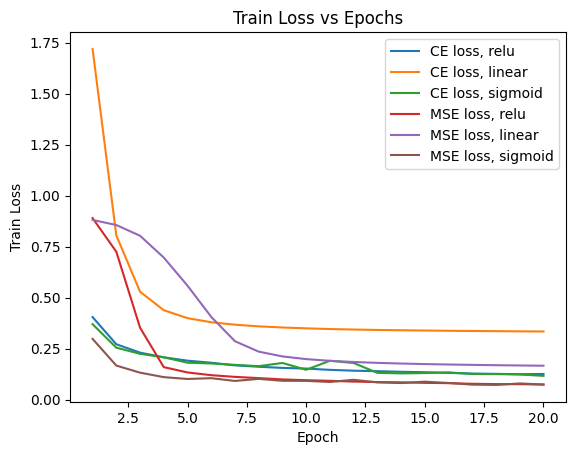

In [156]:
learning_rates = [0.001, 0.0001, 0.5, 0.001, 0.0001, 0.5]
configuration([500, 250, 100], learning_rates)